# Chapter 13 - Dimensionality Reduction (Chain of Tasks)

In [ ]:
## we will first install the needed libs
## ! pip install transformers

### General Python Libs

In [5]:

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# SKlearn Models
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, RobustScaler,Normalizer,MinMaxScaler
from sklearn.manifold import TSNE

from sklearn.metrics.pairwise import cosine_similarity

# Clustering algorithms
## GaussianMixture
from sklearn.mixture import GaussianMixture
## KMeans
from sklearn.cluster import KMeans
# pytorch models
import torch


# Tokenizers
from transformers import AutoTokenizer, AutoModel
# Bert Model
from transformers import BertTokenizer, BertModel

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler

# 1. Text Classification (Term Frequency)
## Load the data
## Get the Textual Field of the Academic Papers database

In [6]:
# to privent SSL error while loading locally
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
df_papers = pd.read_csv("https://raw.githubusercontent.com/umassdgithub/DataViz-Fall2025/refs/heads/main/Week-8-ForceSimulator/data/data_scopus.csv")

In [7]:
df_papers[['EID','Title','Abstract']].head(3)

,EID,Title,Abstract
0,2-s2.0-85086464158,Virtual reality applications for the built env...,With its advanced capabilities of immersive an...
1,2-s2.0-85082875828,"Self-tracking while doing sport: Comfort, moti...",The spread of wearable technologies is paving ...
2,2-s2.0-85078194587,"Bridge damage: Detection, IFC-based semantic e...",Building Information Modeling (BIM) representa...


### verview the dataset

In [ ]:
df_papers

,Title,Year,EID,Abstract,Publisher,Conference name,Conference date,Authors,Author(s) ID,Authors with affiliations,Source title,Abbreviated Source Title,Cited by
0,Virtual reality applications for the built env...,2020,2-s2.0-85086464158,With its advanced capabilities of immersive an...,Elsevier B.V.,NaN,NaN,"Zhang Y., Liu H., Kang S.-C., Al-Hussein M.",57202536919;53984550800;57215426514;6603541102;,"Zhang, Y., Department of Civil and Environment...",Automation in Construction,Autom Constr,NaN
1,"Self-tracking while doing sport: Comfort, moti...",2020,2-s2.0-85082875828,The spread of wearable technologies is paving ...,Academic Press,NaN,NaN,"Rapp A., Tirabeni L.",23398572100;57191836654;,"Rapp, A., Computer Science Department, Univers...",International Journal of Human Computer Studies,Int J Hum Comput Stud,NaN
2,"Bridge damage: Detection, IFC-based semantic e...",2020,2-s2.0-85078194587,Building Information Modeling (BIM) representa...,Elsevier B.V.,NaN,NaN,"Isailović D., Stojanovic V., Trapp M., Richter...",57205293410;56421700900;24831175200;3619515940...,"Isailović, D., Department for Construction Pro...",Automation in Construction,Autom Constr,NaN
3,VR system for spatio-temporal visualization of...,2019,2-s2.0-85075706132,Social media analysis is helpful to understand...,Springer,NaN,NaN,"Okada K., Yoshida M., Itoh T., Czauderna T., S...",57201502480;57171240600;35373203100;2592569550...,"Okada, K., Ochanomizu University, Tokyo, Japan...",Multimedia Tools and Applications,Multimedia Tools Appl,NaN
4,DiseaSE: A biomedical text analytics system fo...,2019,2-s2.0-85074886243,Due to increasing volume and unstructured natu...,Academic Press Inc.,NaN,NaN,"Abulaish M., Parwez M.A., Jahiruddin",6505934038;57202719622;35590173900;,"Abulaish, M., Department of Computer Science, ...",Journal of Biomedical Informatics,J. Biomed. Informatics,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,Propositional n-traces: visualizing a problem ...,1995,2-s2.0-0029533881,"As part of an inter-disciplinary effort, we ar...","IEEE, Los Alamitos, CA, United States",Proceedings of the 1995 6th Annual IEEE Confer...,29 October 1995 through 3 October 1995,"Prevost Nathalie, Jorgenson Loki, Jennings R.E...",6603428086;55937115800;16412349600;7003348138;,"Prevost, Nathalie, Simon Fraser Univ, Burnaby,...",Proceedings of the IEEE Visualization Conference,Proc IEEE Visual Conf,NaN
566,Fast algorithms for visualizing fluid motion i...,1995,2-s2.0-0029487213,The plotting of streamlines is an effective wa...,"IEEE, Los Alamitos, CA, United States",Proceedings of the 1995 6th Annual IEEE Confer...,29 October 1995 through 3 October 1995,"Ueng S.K., Sikorski K., Ma Kwan-Liu",7006871353;35194562700;35242602500;,"Ueng, S.K., Univ of Utah, Salt Lake City, Unit...",Proceedings of the IEEE Visualization Conference,Proc IEEE Visual Conf,10.0
567,Fast normal estimation using surface character...,1995,2-s2.0-0029488955,To visualize the volume data acquired from com...,"IEEE, Los Alamitos, CA, United States",Proceedings of the 1995 6th Annual IEEE Confer...,29 October 1995 through 3 October 1995,"Shin Byeong Seok, Shin Yeong Gil",7103027750;7402816561;,"Shin, Byeong Seok, Seoul Natl Univ, Seoul, Sou...",Proceedings of the IEEE Visualization Conference,Proc IEEE Visual Conf,4.0
568,Supporting heterogeneous data import for data ...,1995,2-s2.0-0029193549,Effective data visualization requires the comb...,"ACM, New York, NY, United States",Proceedings of the 1995 ACM Symposium on Appli...,26 February 1995 through 28 February 1995,"Ford R., Thompson R., Thompson D.",57214569671;8713633000;7404935132;,"Ford, R., Univ of Montana, Missoula, United St...",Proceedings of the ACM Symposium on Applied Co...,Proc ACM Symp Appl Computing,NaN


### 1.1 Extract abstracts and titles

In [8]:
EIDs = df_papers['EID'].values
titles = df_papers['Title'].values
abstracts = df_papers['Abstract'].values

### TF-IDF vectorization for abstracts and titles
TF-IDF: term frequency-inverse document frequency
<div>
<img src='https://miro.medium.com/v2/resize:fit:1358/1*V9ac4hLVyms79jl65Ym_Bw.jpeg' width=600px/>
</div>

### 1.2 Apply tokenizer
Check this link for more details
https://smltar.com/stopwords

In [9]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english') ##  eliminate words that are so widely used that they carry very little useful information
abstracts_tfidf = tfidf_vectorizer.fit_transform(abstracts)
titles_tfidf = tfidf_vectorizer.fit_transform(titles)

### 1.3 Concatenate the TF-IDF vectors

In [10]:
tfidf_matrix = np.hstack((abstracts_tfidf.toarray(), titles_tfidf.toarray()))

In [11]:
tfidf_matrix.shape

(570, 9413)

### 1.4 Using Scalers to Normalize Data

### There are several methods
- StandardScaler
- RobustScaler
- Normalizer
- MinMaxScaler

In [12]:
#scaler = StandardScaler()
scaler = RobustScaler()
#scaler = Normalizer()
#scaler = MinMaxScaler()
tfidf_matrix_standardized = scaler.fit_transform(tfidf_matrix)

### 1.5 Overview tfidf_matrix_standardized

In [13]:
tfidf_matrix_standardized

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# 2. Dimensionality Reduction of the tfidf Matrix using PCA
## Principal Component Analysis: A statistical procedure that summarizes information in large data tables using a smaller set of "summary indices".

In [24]:
n_components = 4  # Number of components to keep
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(tfidf_matrix_standardized.T)

## 2.1 Visualize the principal components

In [25]:
features = tfidf_vectorizer.get_feature_names_out()
components = pca.components_

df_components = pd.DataFrame(components).T

In [26]:
df_components

,0,1,2,3
0,0.005116,0.016362,-0.020615,-0.001307
1,0.007017,0.018609,0.047082,0.019837
2,0.006906,0.017325,-0.004015,-0.037691
3,0.009381,0.025941,-0.023991,0.008062
4,0.015264,0.042921,0.017493,0.032585
...,...,...,...,...
565,0.000472,-0.000378,0.002686,0.010025
566,0.010221,0.030971,-0.026607,-0.017996
567,0.015626,0.033867,0.043840,-0.003167
568,0.007079,0.015331,0.000466,0.035216


## 2.2 Overview of the compoenent I

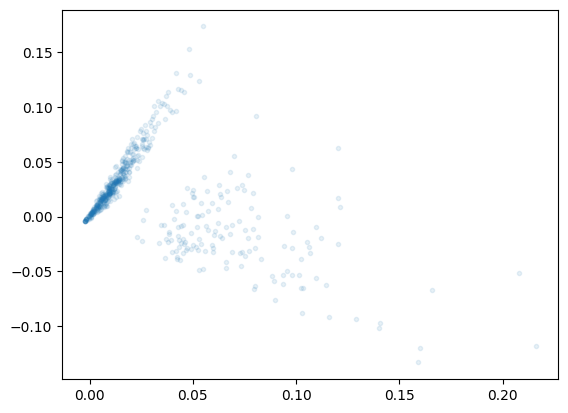

In [33]:
# df_filtered = df_components[df_components[1]<(df_components[1].median()+.001)]
df_filtered = df_components.copy()
f,ax = plt.subplots(1,1)
ax.plot(df_filtered[0],df_filtered[1],'.',alpha=.1)

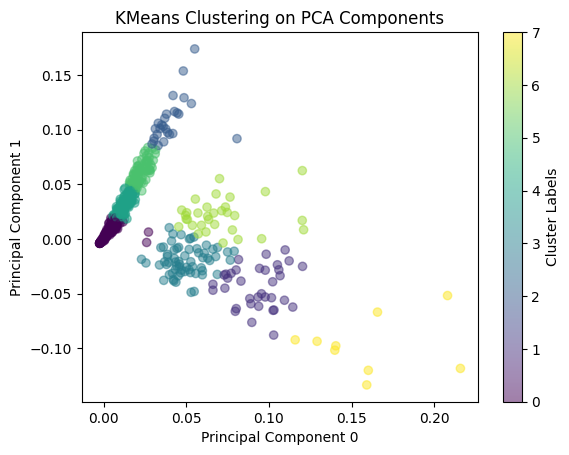

In [37]:
n_clusters = 8  # You can adjust the number of clusters
kmeans_pca = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)
kmeans_labels_pca = kmeans_pca.fit_predict(df_filtered.iloc[:, :n_components]) # Select only the numerical PCA components

df_filtered['kmeans'] = kmeans_labels_pca

f,ax = plt.subplots(1,1)
scatter = ax.scatter(df_filtered[0],df_filtered[1],c=df_filtered['kmeans'],cmap='viridis',alpha=.5)
ax.set_title('KMeans Clustering on PCA Components')
ax.set_xlabel('Principal Component 0')
ax.set_ylabel('Principal Component 1')
plt.colorbar(scatter, label='Cluster Labels')
plt.show()

## 2.3 Overview of the compoenent II

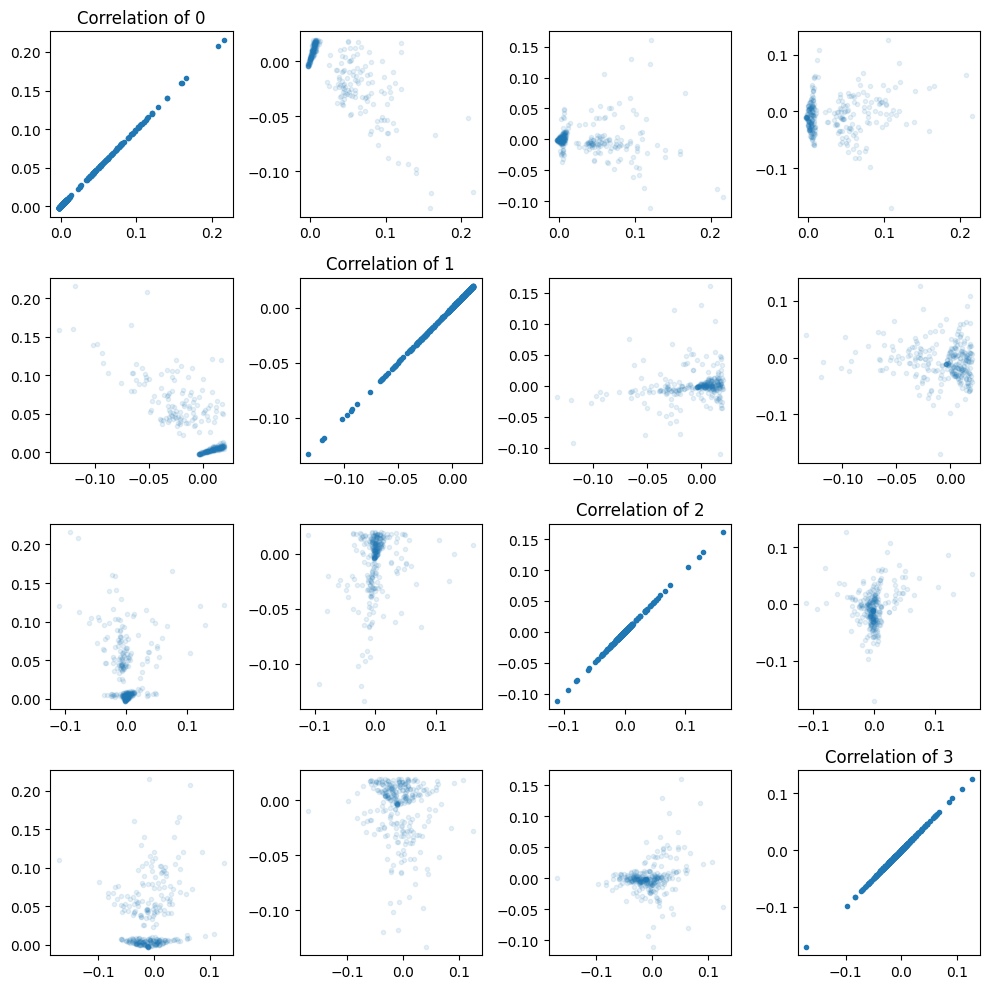

In [29]:
f, ax = plt.subplots(n_components, n_components, figsize=(10, 10))
axs = np.ravel(ax)


df_filtered = df_components[df_components[1] < (df_components[1].median() + .001)]


for i in range(n_components):
    for j in range(n_components):
        ax = axs[i * n_components + j]  # Select the correct subplot

        if i == j:
            # Plot the correlation line (diagonal)
            ax.plot(df_filtered[df_filtered.columns[i]], df_filtered[df_filtered.columns[j]], '.')
            ax.set_title(f'Correlation of {df_filtered.columns[i]}')
        else:
            # Plot the scatter plot for off-diagonal elements
            ax.plot(df_filtered[df_filtered.columns[i]], df_filtered[df_filtered.columns[j]], '.', alpha=0.1)

plt.tight_layout()

# 3. Dimensionality Reduction of the tf-idf Matrix using t-SNE
## 3.1 T-distributed Stochastic Neighbor Embedding.

In [30]:
n_components = 2  # Number of components
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=0)
tsne_result = tsne.fit_transform(tfidf_matrix_standardized)

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


### 3.2 Overview of the new components I

In [31]:
df_tsne = pd.DataFrame(tsne_result)
df_tsne.head()

,0,1
0,-6.230966,-7.456635
1,6.468396,4.178863
2,-18.706879,-8.238303
3,1.927932,-5.853457
4,4.900673,-0.192417


In [32]:
df_tsne.shape

(570, 2)

## 3.3 Overview of the compoenent II

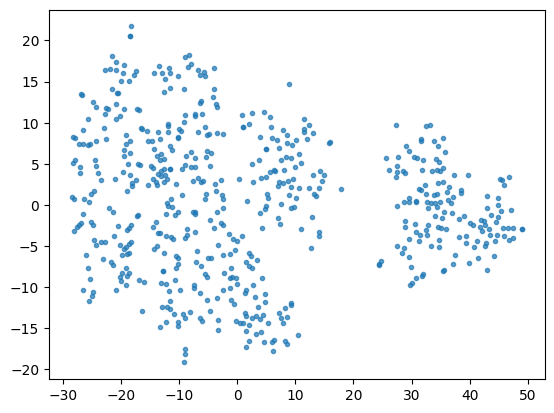

In [23]:
f,ax = plt.subplots(1,1)
ax.plot(df_tsne[0],df_tsne[1],'.',alpha=.7)

# 4. clustering

##  4.1 Apply Gaussian Mixture Models (GMM) - with preset cluster number
See the explanations about GMM [here](https://www.youtube.com/watch?time_continue=71&v=wT2yLNUfyoM&embeds_referring_euri=https%3A%2F%2Fwww.google.com%2Fsearch%3Fq%3DApply%2BGaussian%2BMixture%2BModels%26rlz%3D1C5MACD_enUS1019US1019%26oq%3DApply%2BGaussian%2BMixture%2BModels%26gs_lcr&source_ve_path=Mjg2NjY&themeRefresh=1).

In [ ]:
n_clusters = 8  # Number of clusters - we can change this according to the structure...
gmm = GaussianMixture(n_components=n_clusters, random_state=0)
gmm_labels = gmm.fit_predict(tsne_result)

In [ ]:
df_tsne['GMM'] = gmm_labels

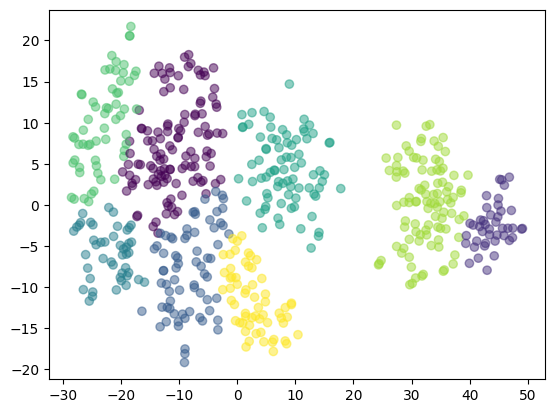

In [ ]:
f,ax = plt.subplots(1,1)
ax.scatter(df_tsne[0],df_tsne[1],c=df_tsne['GMM'],cmap='viridis',alpha=.5)

##  4.2 Apply kmeans

In [ ]:
n_clusters = 8  # Number of clusters

kmeans = KMeans(n_clusters=n_clusters)  # Specify the number of clusters

# Fit the model to the TSNE Components
kmeans_labels = kmeans.fit_predict(tsne_result)
df_tsne['kmeans'] = kmeans_labels

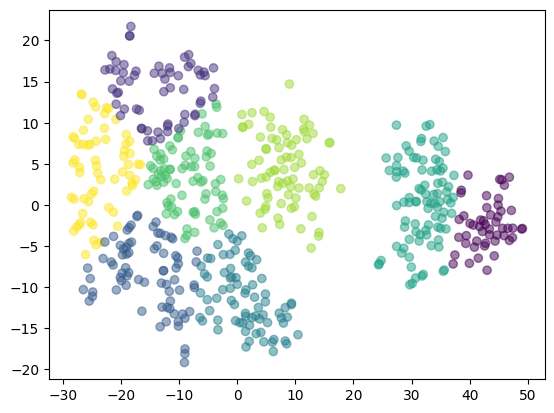

In [ ]:
f,ax = plt.subplots(1,1)
ax.scatter(df_tsne[0],df_tsne[1],c=df_tsne['kmeans'],cmap='viridis',alpha=.5)

## Check if the clusters mean anything

In [ ]:
for k in df_papers[df_tsne['kmeans'] ==1]['Title']:
    print(k)
    print("--------------------------------------")

Remote interactive collaboration in facilities management using BIM-based mixed reality
--------------------------------------
Building information modelling for off-site construction: Review and future directions
--------------------------------------
Research on the Smart Information System of Weihe River Basin
--------------------------------------
Ontology-driven development of web services to support district energy applications
--------------------------------------
Graphical visualization of educational information during the studying process of the students in universities
--------------------------------------
Implementation and evaluation of distributed graph sampling methods with spark
--------------------------------------
Development of support tool to improve indirectly consciousness of energy saving
--------------------------------------
Describing clothing in human images: A parsing-pose integrated approach
--------------------------------------
Campus explorer: Facilit

# 5. Use BERT (LLM) to label the clusters (instead of TF-IDF)
<img src='https://machinelearningmastery.com/wp-content/uploads/2021/08/attention_research_1.png' width=400px>

## 5.1 Load pre-trained BERT tokenizer and model

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')



# Tokenize and convert abstracts to BERT embeddings
embeddings = []

for abstract in abstracts:
    inputs = tokenizer(abstract, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings.append(outputs.last_hidden_state.mean(dim=1).squeeze().numpy())
np.save('embeddings.npy', embeddings)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
embeddings[0].shape

(768,)

## Embeddings

In [ ]:
print(f"{len(embeddings)} x {embeddings[0].size} ")

570 x 768 


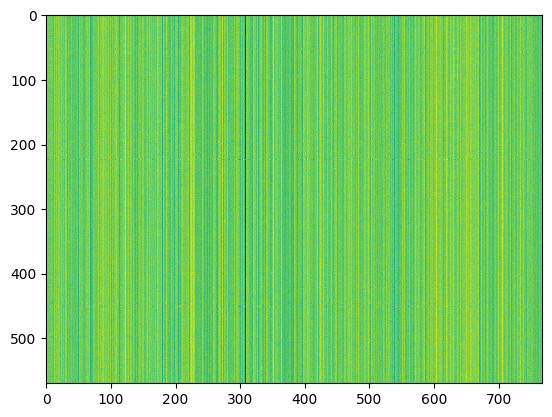

In [ ]:
plt.imshow(embeddings, cmap='viridis', interpolation='nearest')

In [ ]:
# Load embeddings from the file
# embeddings = np.load('embeddings.npy', allow_pickle=True)

## 5.2 Use Bert Embeddings to Classify

### Now 'embeddings' contains BERT embeddings for each abstract


### 5.3 Apply PCA on Bert embeddings

In [ ]:
# Apply PCA to reduce dimensions to 2D
n_components = 8
pca = PCA(n_components=n_components)
bert_pca = pca.fit_transform(embeddings)


In [ ]:
bert_pca

array([[-2.03640998,  0.96562763,  0.40965785, ...,  1.28594266,
         0.47092571,  0.26181762],
       [-2.05434744, -0.18162726, -0.76618918, ...,  0.36066732,
         0.25524012, -0.58515463],
       [ 0.14907388, -0.23633394,  0.72336692, ..., -0.05029965,
        -0.28702956,  0.80298717],
       ...,
       [ 2.03419337, -0.63147717, -0.3504542 , ...,  0.33305749,
         0.56167687, -0.14252534],
       [-0.19348794,  1.61494886,  0.99126818, ..., -0.77309157,
         0.43614042, -0.39789031],
       [-0.00775254, -0.78374256,  0.09466595, ...,  0.27276451,
        -0.1259184 , -0.71867696]])

In [ ]:
n_clusters = 8
bert_pca_kmeans = KMeans(n_clusters=n_clusters)  # Specify the number of clusters
kmeans_labels = kmeans.fit_predict(bert_pca)

## Overview the bert_pca variable

In [ ]:
bert_pca.shape

(570, 8)

### Components of 7 and 1

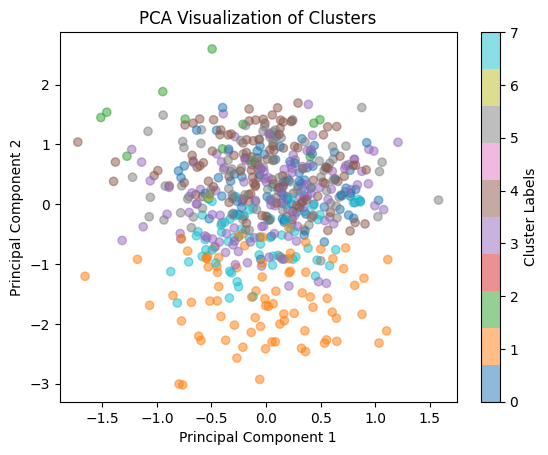

In [ ]:
# Create a scatter plot of the 2D embeddings with cluster labels
plt.scatter(bert_pca[:, 7], bert_pca[:, 1], c=kmeans_labels, cmap='tab10', alpha=0.5)
plt.title('PCA Visualization of Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster Labels')
plt.show()

### Components of 1 and 0

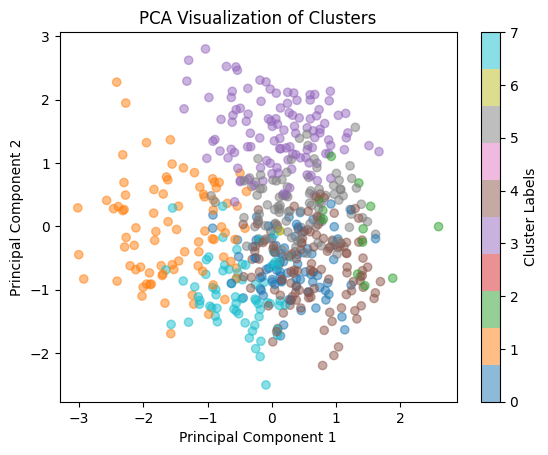

In [ ]:

# Create a scatter plot of the 2D embeddings with cluster labels
plt.scatter(bert_pca[:, 1], bert_pca[:, 0], c=kmeans_labels, cmap='tab10', alpha=0.5)
plt.title('PCA Visualization of Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster Labels')
plt.show()

# 6 Cosine Similarity on Embeddings

In [ ]:
similarity_matrix = cosine_similarity(embeddings)
df_link_matrix = pd.DataFrame(similarity_matrix)

In [ ]:
similarity_matrix

array([[1.0000001 , 0.8992721 , 0.867142  , ..., 0.7953824 , 0.8470583 ,
        0.8337585 ],
       [0.8992721 , 1.0000001 , 0.84519094, ..., 0.8123547 , 0.8175867 ,
        0.8548369 ],
       [0.867142  , 0.84519094, 1.        , ..., 0.8751446 , 0.8557906 ,
        0.8669492 ],
       ...,
       [0.7953824 , 0.8123547 , 0.8751446 , ..., 1.0000005 , 0.83605903,
        0.8622619 ],
       [0.8470583 , 0.8175867 , 0.8557906 , ..., 0.83605903, 1.        ,
        0.83321047],
       [0.8337585 , 0.8548369 , 0.8669492 , ..., 0.8622619 , 0.83321047,
        1.0000002 ]], dtype=float32)

### 6.1 Apply scale on the similarities

In [ ]:
df_link_matrix_scaled = pd.DataFrame(scaler.fit_transform(df_link_matrix), columns=df_link_matrix.columns)

## Overview data

In [ ]:
df_link_matrix_scaled.head()

,0,1,2,3,4,5,6,7,8,9,...,560,561,562,563,564,565,566,567,568,569
0,2.507192,0.711109,-0.571418,-1.115981,-0.052668,0.581667,-0.167547,0.665033,0.657569,0.815751,...,-1.010678,0.569148,0.445036,0.319996,-0.862700,-0.253121,-0.932874,-1.485638,-0.256092,-1.108152
1,0.678065,2.760108,-1.278676,-0.486002,-0.116349,-0.510530,-0.192187,0.370168,-0.203159,-0.257810,...,-0.598973,1.097991,0.817094,-0.220588,-0.851869,-0.197788,-0.739137,-1.161599,-0.843387,-0.332262
2,0.094613,-0.389003,3.709226,-0.309303,0.687185,0.531450,0.929620,0.323963,0.785815,0.476746,...,-0.267625,-0.456876,-0.789182,-0.354577,-0.386165,-0.310081,-0.110796,0.037201,-0.082079,0.113589
3,0.190847,0.555547,0.390766,3.073066,0.663953,0.830114,0.253238,0.254682,0.180977,0.442437,...,0.390982,0.159383,0.791235,0.667540,0.821788,0.665871,0.527191,0.495868,0.334848,0.234967
4,0.385805,0.336660,0.811218,0.091531,3.163112,0.302966,0.824981,0.885394,0.519970,0.449893,...,-0.084988,-0.394268,0.183497,-0.159446,-0.435195,-0.231209,-0.285994,-0.383637,0.025790,0.810688


### 6.2 Use networkX and a similarity threshold to build the network

In [ ]:
# Create an empty undirected graph
G = nx.Graph()

# Define the threshold for creating edges
threshold = 1.5

# Iterate over rows and columns to add edges with weights
for i, source_node in enumerate(df_link_matrix_scaled.columns):
    for j, target_node in enumerate(df_link_matrix_scaled.columns):
        if i < j:  # Only consider the upper triangle of the matrix
            weight = df_link_matrix_scaled.iloc[i, j]
            if weight >= threshold:
                G.add_edge(source_node, target_node, weight=weight)

In [ ]:


# Create an empty undirected graph
G = nx.Graph()

# Define the threshold for creating edges
threshold = 1.5

# Iterate over rows and columns to add edges with weights
for i in range(len(df_link_matrix_scaled.columns)):
    source_node = df_link_matrix_scaled.columns[i]

    # Ensure the node exists in the graph
    G.add_node(source_node)  # Add the node if not already added

    for j in range(i + 1, len(df_link_matrix_scaled.columns)):
        target_node = df_link_matrix_scaled.columns[j]
        weight = df_link_matrix_scaled.iloc[i, j]
        if weight >= threshold:
            G.add_edge(source_node, target_node, weight=weight)

    # Add the title as an attribute to each node
    G.nodes[source_node]['title'] = df_papers['Title'].iloc[i]

# Remove nodes with degree less than 2
for node in list(G.nodes):  # Convert to list to avoid modifying the graph while iterating
    if G.degree(node) < 2:
        G.remove_node(node)


### 6.3 Export the network

In [ ]:
# Specify the file path where you want to save the GEXF file
gexf_file_path = "Documents_graph.gexf"

# Export the graph to a GEXF file
nx.write_gexf(G, gexf_file_path)